In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_excel("C:/Users/MODE/Downloads/archive (1)/Online Retail.xlsx")

In [3]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
df.drop(["StockCode", "Description"], axis=1, inplace=True)

In [5]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [6]:
df.isnull().sum()

InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Step 1: Data Cleaning
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

In [8]:
df.isnull().sum()

InvoiceNo      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
df.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [10]:
# Step 2: Feature Engineering
df["CustomerID"] = df["CustomerID"].astype(int)
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Reference date for Recency
ref_date = df["InvoiceDate"].max()

# Group by CustomerID to get RFM-style features
customer_df = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,
    "InvoiceNo": "nunique",
    "Quantity": "sum",
    "TotalPrice": "sum"
}).reset_index()

# Rename columns
customer_df.columns = ["CustomerID", "Recency", "Frequency", "TotalQuantity", "TotalSpend"]

print(customer_df.head())

   CustomerID  Recency  Frequency  TotalQuantity  TotalSpend
0       12346      325          1          74215    77183.60
1       12347        1          7           2458     4310.00
2       12348       74          4           2341     1797.24
3       12349       18          1            631     1757.55
4       12350      309          1            197      334.40


1. Distributions of Key Features

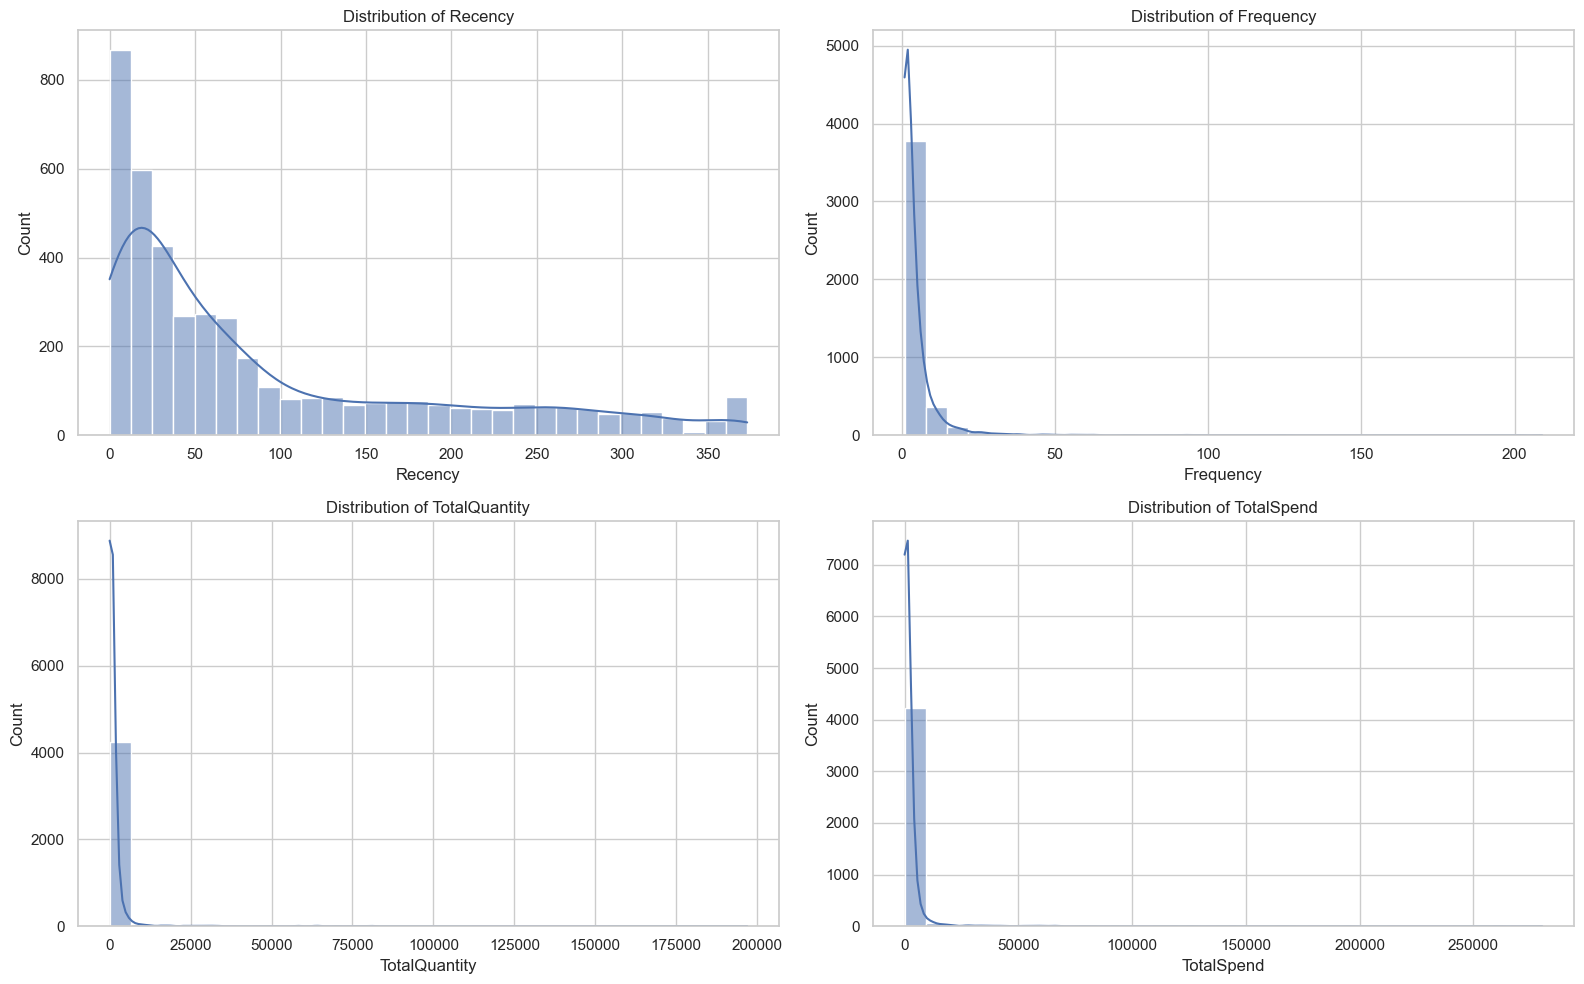

In [11]:
# Set style
sns.set(style="whitegrid")

# Plot distributions
features = ["Recency", "Frequency", "TotalQuantity", "TotalSpend"]
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(customer_df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

2. Correlation Heatmap

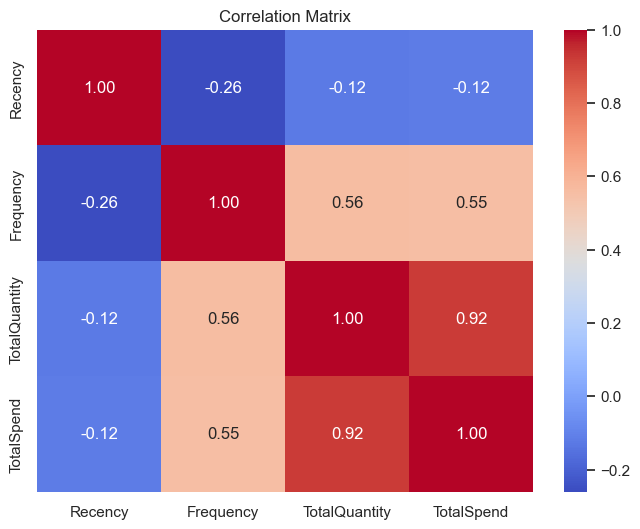

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(customer_df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

3. Pair Plot for Feature Interactions

C:\Users\MODE\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


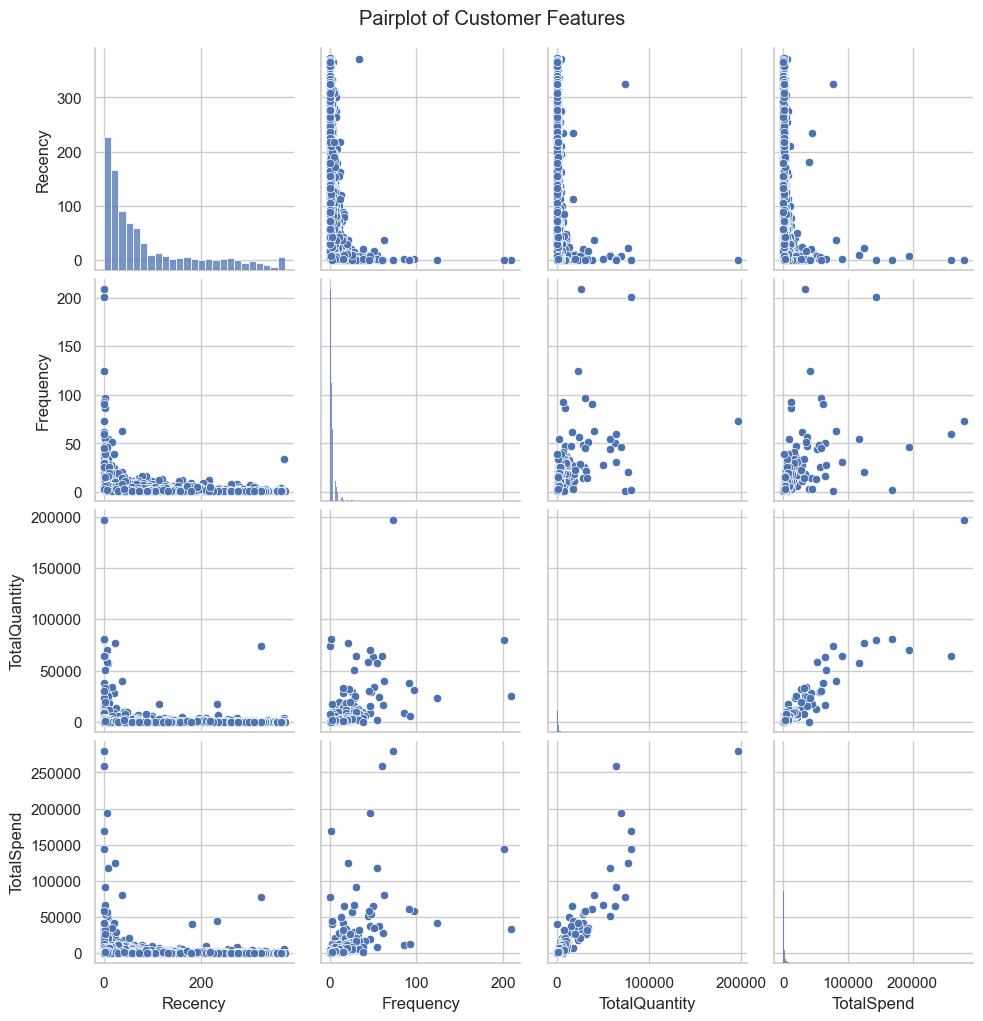

In [13]:
sns.pairplot(customer_df[features])
plt.suptitle("Pairplot of Customer Features", y=1.02)
plt.show()

In [14]:
# Select features for clustering
features = ["Recency", "Frequency", "TotalQuantity", "TotalSpend"]
X = customer_df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Elbow Method

C:\Users\MODE\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\MODE\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\MODE\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\MODE\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

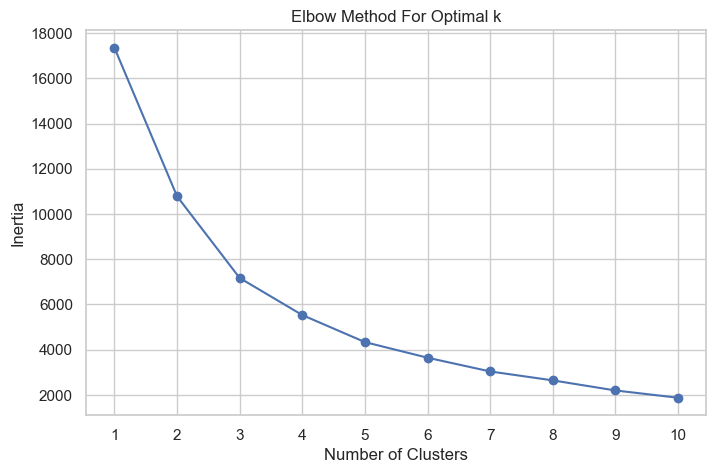

In [15]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid(True)
plt.show()

C:\Users\MODE\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


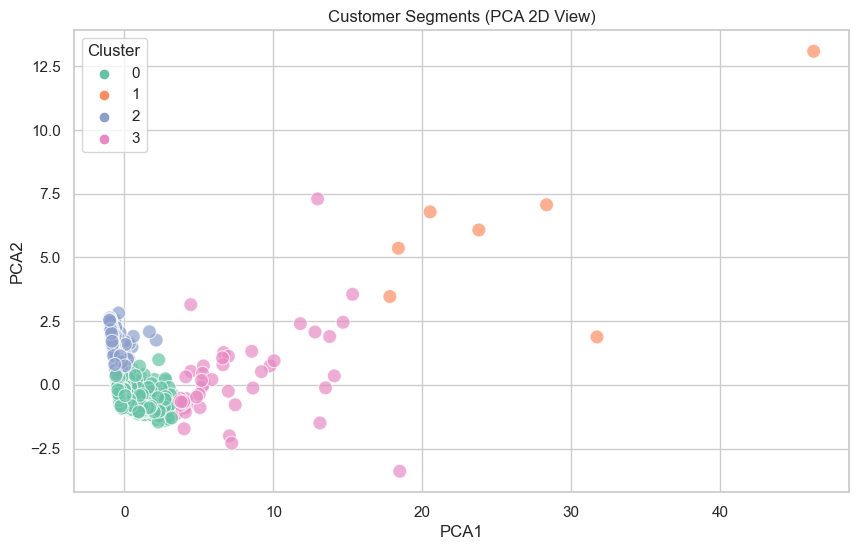

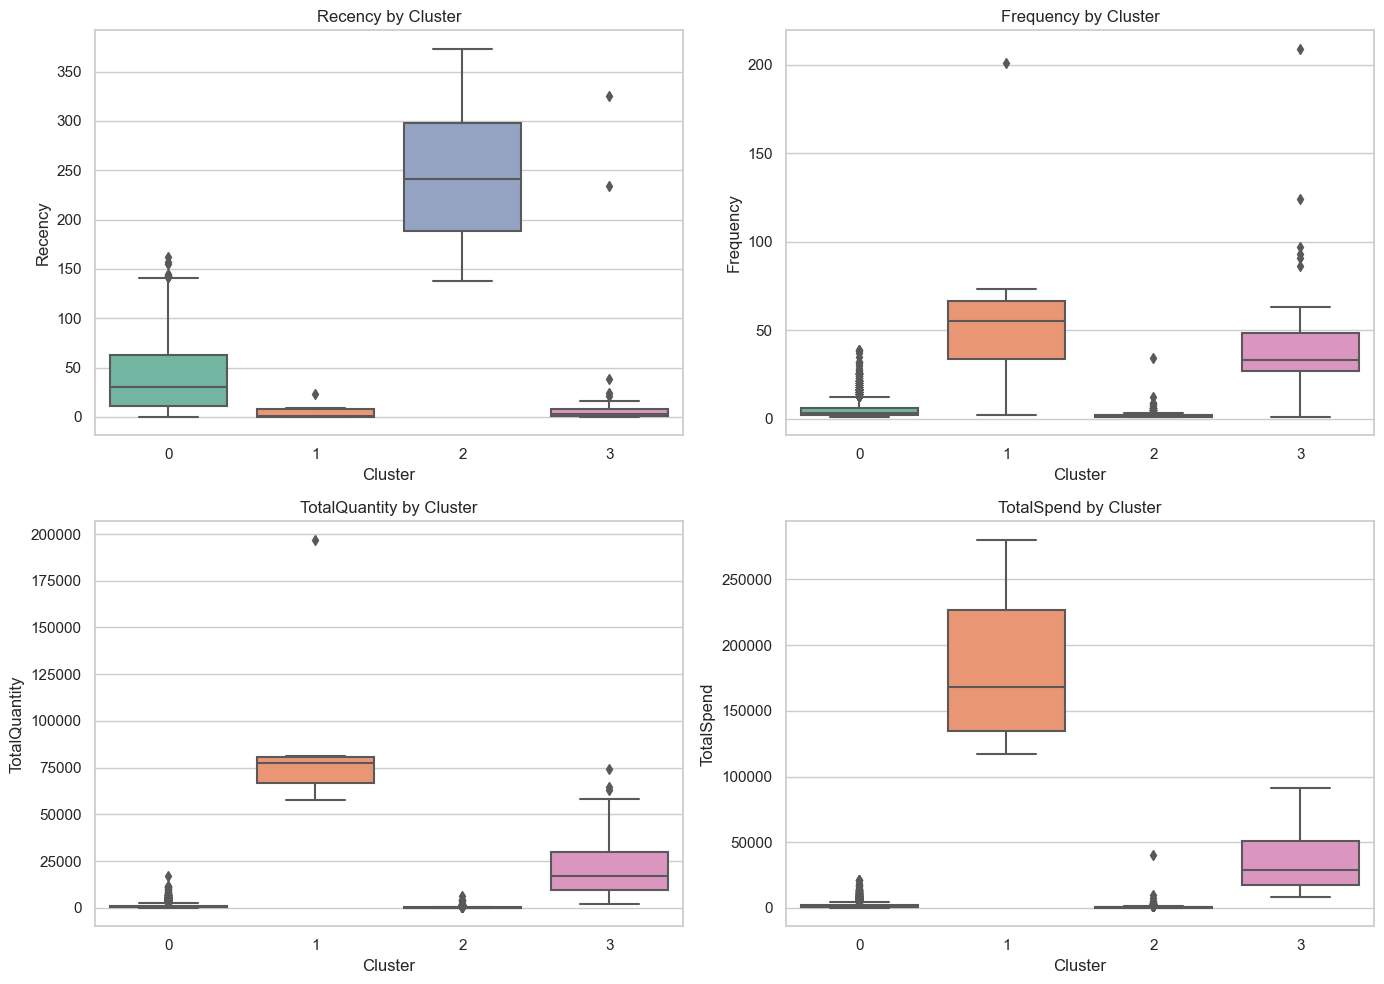

In [16]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Add PCA components to DataFrame
customer_df['PCA1'] = components[:, 0]
customer_df['PCA2'] = components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100, alpha=0.7)
plt.title('Customer Segments (PCA 2D View)')
plt.show()

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=customer_df, x='Cluster', y=feature, palette='Set2')
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

In [17]:
# Cluster profiling
cluster_profile = customer_df.groupby('Cluster').agg({
    "Recency": "mean",
    "Frequency": "mean",
    "TotalQuantity": "mean",
    "TotalSpend": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "NumCustomers"}).round(2)

cluster_profile

,Recency,Frequency,TotalQuantity,TotalSpend,NumCustomers
Cluster,,,,,
0,40.78,4.47,991.42,1677.10,3204
1,5.71,65.43,89650.43,184143.69,7
2,246.14,1.58,267.63,520.06,1079
3,16.54,42.85,22395.52,35163.48,48


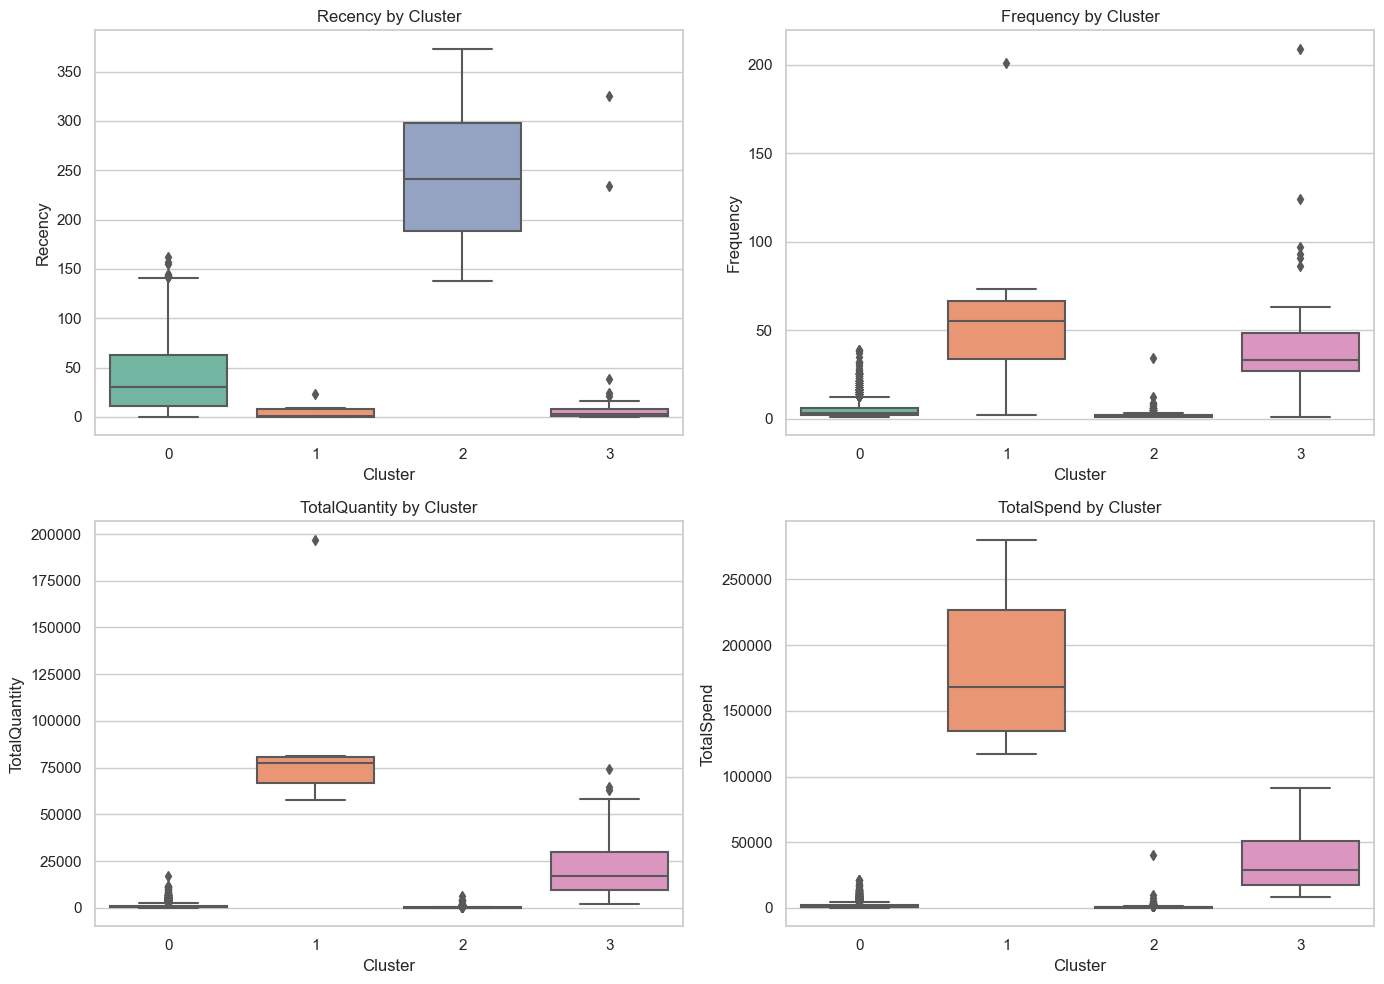

In [18]:
features = ["Recency", "Frequency", "TotalQuantity", "TotalSpend"]

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=customer_df, x="Cluster", y=feature, palette="Set2")
    plt.title(f"{feature} by Cluster")
plt.tight_layout()
plt.show()